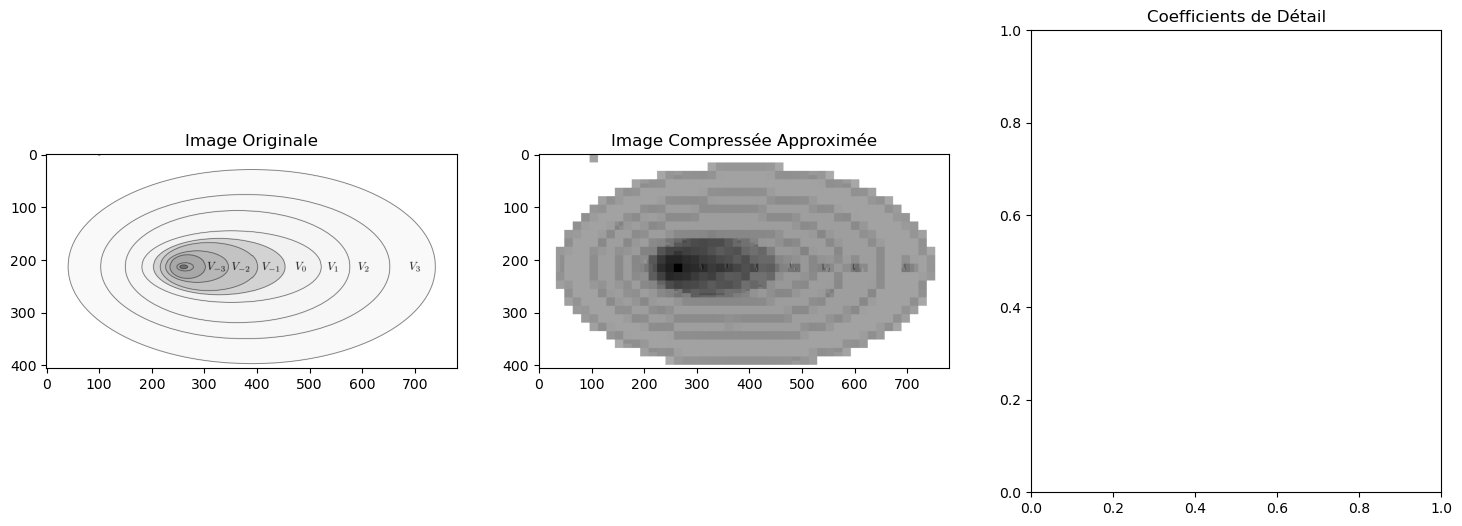

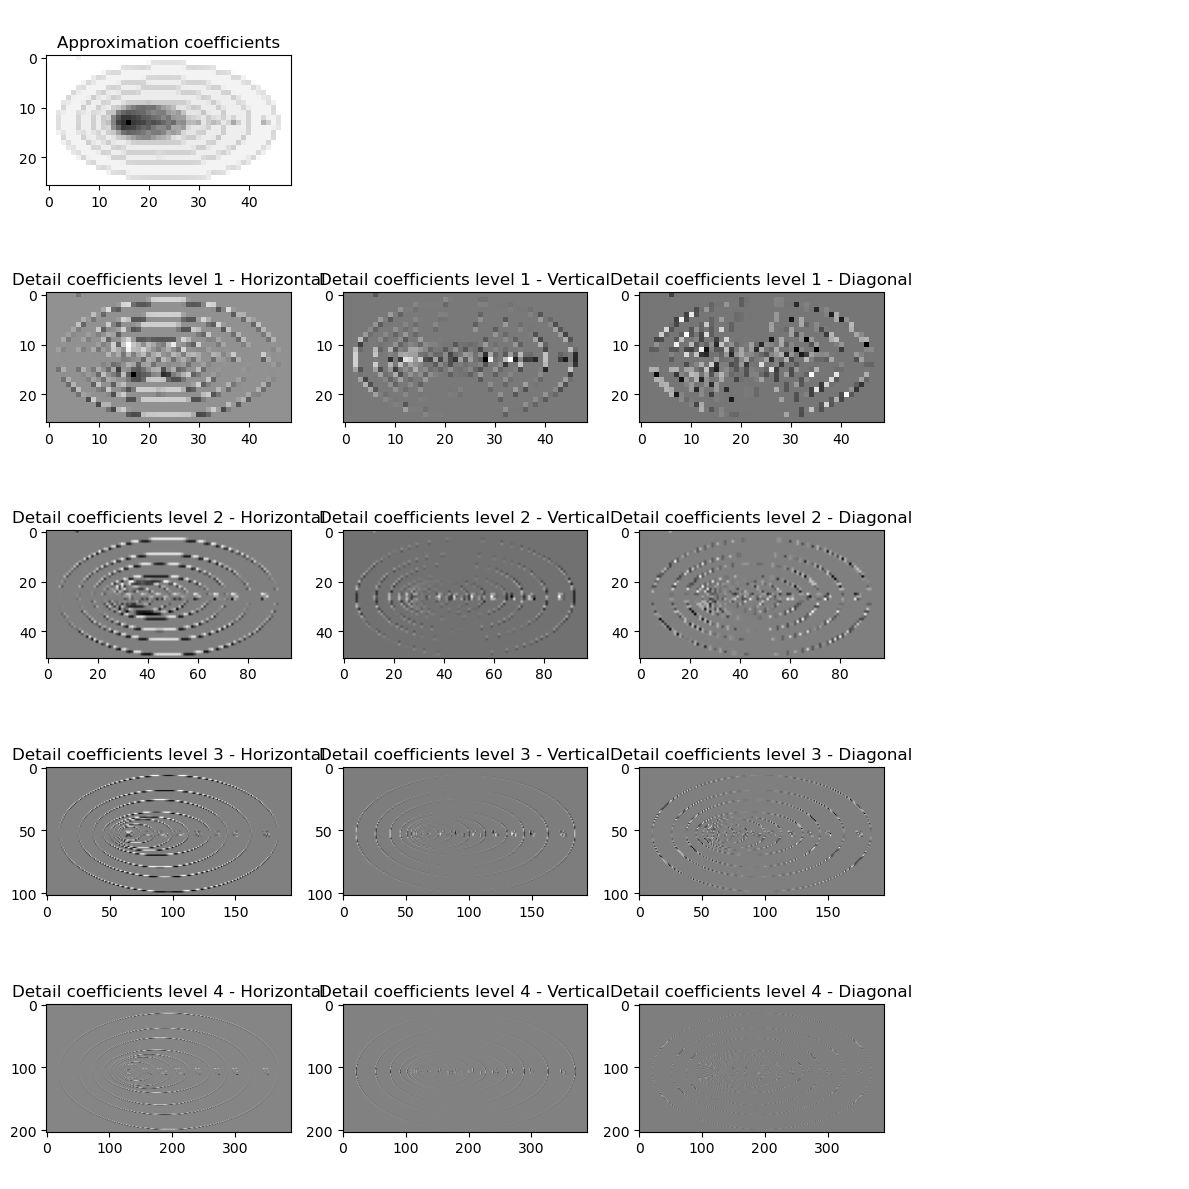

In [4]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage import io, color

class EZW:
    def __init__(self, image, wavelet='haar', level=1):
        """
        Initialisation de l'algorithme EZW avec les paramètres de l'image à compresser,
        le type d'ondelette à utiliser et le niveau de décomposition.

        :param image: L'image à compresser
        :param wavelet: Type d'ondelette à utiliser (par défaut 'haar')
        :param level: Niveau de décomposition en ondelettes (par défaut 1)
        """
        self.image = image  # Image à compresser
        self.wavelet = wavelet  # Type d'ondelette
        self.level = level  # Niveau de décomposition
        self.coeffs = pywt.wavedec2(self.image, self.wavelet, level=self.level)  # Décomposition en ondelettes
        self.max_bits = int(np.log2(np.abs(self.coeffs[0]).max()))  # Nombre maximal de bits pour les coefficients
        self.threshold = 2 ** self.max_bits  # Seuil initial
        self.significant_map = []  # Carte des coefficients significatifs

    def dominant_pass(self):
        """
        Réalise le passage dominant pour identifier les coefficients significatifs
        dont la valeur absolue est supérieure ou égale au seuil actuel.

        :return: Liste des coefficients dominants
        """
        dominant_list = []  # Liste des coefficients dominants
        new_significant_map = []  # Nouvelle carte des coefficients significatifs

        for i, coeff in enumerate(self.coeffs):
            if i == 0:
                significant, new_coeff = self._process_block(coeff, self.threshold)  # Traiter le bloc d'approximation
                dominant_list.append(new_coeff)  # Ajouter les nouveaux coefficients dominants
                new_significant_map.append(significant)  # Ajouter les nouveaux coefficients significatifs
            else:
                level_significant = []  # Coefficients significatifs pour ce niveau
                level_coeffs = []  # Nouveaux coefficients pour ce niveau
                for c in coeff:
                    significant, new_coeff = self._process_block(c, self.threshold)  # Traiter chaque bloc de détails
                    level_significant.append(significant)  # Ajouter les coefficients significatifs
                    level_coeffs.append(new_coeff)  # Ajouter les nouveaux coefficients
                dominant_list.append(tuple(level_coeffs))  # Ajouter les coefficients dominants pour ce niveau
                new_significant_map.append(tuple(level_significant))  # Ajouter la carte des coefficients significatifs pour ce niveau

        self.significant_map = new_significant_map  # Mettre à jour la carte des coefficients significatifs
        return dominant_list

    def subordinate_pass(self):
        """
        Réalise le passage subordonné pour affiner les coefficients significatifs
        en réduisant le seuil de moitié.

        :return: Liste des coefficients subordonnés affinés
        """
        self.threshold //= 2  # Réduire le seuil de moitié
        subordinate_list = []  # Liste des coefficients subordonnés affinés

        for i, coeff in enumerate(self.coeffs):
            if i == 0:
                subordinate_list.append(self._refine_block(coeff, self.threshold, self.significant_map[i]))  # Affiner le bloc d'approximation
            else:
                refined_coeffs = []  # Coefficients affinés pour ce niveau
                for j, c in enumerate(coeff):
                    refined_coeffs.append(self._refine_block(c, self.threshold, self.significant_map[i][j]))  # Affiner chaque bloc de détails
                subordinate_list.append(tuple(refined_coeffs))  # Ajouter les coefficients subordonnés affinés pour ce niveau

        return subordinate_list

    def _process_block(self, block, threshold):
        """
        Traite un bloc de coefficients pour marquer ceux qui sont significatifs
        par rapport au seuil donné.

        :param block: Bloc de coefficients à traiter
        :param threshold: Seuil pour déterminer la significativité
        :return: Carte des coefficients significatifs et bloc avec coefficients significatifs
        """
        significant = np.zeros_like(block)  # Initialiser la carte des coefficients significatifs
        new_coeff = np.zeros_like(block)  # Initialiser les nouveaux coefficients

        for i in range(block.shape[0]):
            for j in range(block.shape[1]):
                if abs(block[i, j]) >= threshold:  # Vérifier si le coefficient est significatif
                    significant[i, j] = np.sign(block[i, j])  # Marquer le coefficient comme significatif
                    new_coeff[i, j] = block[i, j]  # Conserver le coefficient

        return significant, new_coeff

    def _refine_block(self, block, threshold, significant):
        """
        Affine les coefficients significatifs dans un bloc en réduisant le seuil.

        :param block: Bloc de coefficients à affiner
        :param threshold: Seuil pour le raffinement
        :param significant: Carte des coefficients significatifs
        :return: Bloc de coefficients affinés
        """
        refined = np.zeros_like(block)  # Initialiser les coefficients affinés

        for i in range(block.shape[0]):
            for j in range(block.shape[1]):
                if significant[i, j] != 0:  # Vérifier si le coefficient est significatif
                    if abs(block[i, j]) >= threshold:  # Vérifier si le coefficient est toujours significatif
                        refined[i, j] = np.sign(block[i, j])  # Conserver le coefficient
                    else:
                        refined[i, j] = 0  # Marquer le coefficient comme non significatif

        return refined

    def compress(self):
        """
        Compresse l'image en appliquant les passes dominantes et subordonnées
        jusqu'à ce que le seuil soit inférieur à 1.

        :return: Données compressées
        """
        compressed_data = []  # Initialiser les données compressées

        while self.threshold >= 1:
            dominant_pass_result = self.dominant_pass()  # Effectuer le passage dominant
            subordinate_pass_result = self.subordinate_pass()  # Effectuer le passage subordonné
            compressed_data.append((dominant_pass_result, subordinate_pass_result))  # Ajouter les résultats des passes dominantes et subordonnées

        return compressed_data

    def approximate_image(self, compressed_data):
        """
        Génère une image approximée à partir des données compressées.

        :param compressed_data: Données compressées
        :return: Image approximée reconstruite
        """
        approximated_coeffs = [np.zeros_like(c) if not isinstance(c, tuple) else [np.zeros_like(sub_c) for sub_c in c] for c in self.coeffs]  # Initialiser les coefficients approximés
        threshold = 2 ** self.max_bits  # Seuil initial

        for dominant_pass, _ in compressed_data:
            for i, coeff in enumerate(dominant_pass):
                if i == 0:
                    approximated_coeffs[0] += coeff  # Ajouter les coefficients dominants pour le bloc d'approximation
                else:
                    for j in range(3):
                        approximated_coeffs[i][j] += coeff[j]  # Ajouter les coefficients dominants pour les blocs de détails
            threshold //= 2  # Réduire le seuil de moitié

        return pywt.waverec2(approximated_coeffs, self.wavelet)  # Reconstruire l'image à partir des coefficients approximés

# Fonction pour afficher les coefficients d'ondelettes
def plot_wavelet_coeffs(coeffs):
    """
    Affiche les coefficients d'ondelettes pour chaque niveau de décomposition.
    
    :param coeffs: Coefficients d'ondelettes
    """
    fig, axes = plt.subplots(len(coeffs), 4, figsize=(12, 12))  # Créer une figure avec des sous-graphes
    
    for i, ax in enumerate(axes):
        if i == 0:
            ax[0].imshow(coeffs[i], cmap='gray')  # Afficher les coefficients d'approximation
            ax[0].set_title('Approximation coefficients')  # Titre pour les coefficients d'approximation
            for j in range(1, 4):
                ax[j].axis('off')  # Désactiver les axes inutilisés
        else:
            for j in range(3):
                ax[j].imshow(coeffs[i][j], cmap='gray')  # Afficher les coefficients de détail
                ax[j].set_title(f'Detail coefficients level {i} - {["Horizontal", "Vertical", "Diagonal"][j]}')  # Titre pour les coefficients de détail
            ax[3].axis('off')  # Désactiver les axes inutilisés
    
    plt.tight_layout()  # Ajuster la disposition des sous-graphes
    plt.show()  # Afficher la figure

# Charger l'image depuis un fichier
image_path = 'voisinage.png'
image = io.imread(image_path)  # Lire l'image depuis le chemin spécifié

# Convertir l'image de RGBA à RGB si nécessaire
if image.shape[2] == 4:
    image = color.rgba2rgb(image)  # Convertir l'image en RGB

# Convertir l'image RGB en niveaux de gris
image = color.rgb2gray(image)  # Convertir l'image en niveaux de gris

# Créer une instance de l'algorithme EZW
ezw = EZW(image, wavelet='haar', level=4)

# Compression de l'image
compressed_data = ezw.compress()  # Compresser l'image

# Génération de l'image approximée à partir des données compressées
approximated_image = ezw.approximate_image(compressed_data)  # Générer l'image approximée

# Affichage des résultats
plt.figure(figsize=(18, 6))  # Créer une figure pour afficher les résultats
plt.subplot(1, 3, 1)
plt.title("Image Originale")
plt.imshow(image, cmap='gray')  # Afficher l'image originale

plt.subplot(1, 3, 2)
plt.title("Image Compressée Approximée")
plt.imshow(approximated_image, cmap='gray')  # Afficher l'image compressée approximée

plt.subplot(1, 3, 3)
plt.title("Coefficients de Détail")
plot_wavelet_coeffs(ezw.coeffs)  # Afficher les coefficients d'ondelettes


plt.show()  # Afficher la figure


